# Probabilistic Models and Naive Bayes Classifier (Sklearn)

For this worksheet you will practice probabilistic programming using the `pymc` library. More specifically, you will specify and simulate from Bayes nets, and you will perform classification using a Naive Bayes classifier.

NOTE: The definiteve guide & reference book for PGMs is [Probabilistic Graphical Models: Principles and Techniques](https://mitpress.mit.edu/9780262013192/probabilistic-graphical-models/) by Daphne Koller and Nir Friedman.


## 1. Specifying Probabilistic Models

The `pymc` library provides a range of discrete and continuous [distributions](https://www.pymc.io/projects/docs/en/v5.7.1/api/distributions.html) for modelling. 

### 1.1. Linear Gaussian Bayes net
Consider the linear Gaussian model: 
$$ X\sim \mathcal{N}(0,1), \; Y|X \sim \mathcal{N}(X,1), \; Z|X \sim \mathcal{N}(-X,1), \; W|(Y,Z) \sim \mathcal{N}(Y+Z,1) $$
This is implemented in the code below:

In [1]:
import numpy as np
import pymc as pm
from pymc import Normal, Model

with Model() as my_model:  
    X = Normal( name = "X", mu = 0, sigma = 1 )
    Y = Normal( name = "Y", mu = X, sigma = 1 )
    Z = Normal( name = "Z", mu = -X, sigma = 1 )
    W = Normal( name = "W", mu = Y+Z, sigma = 1 )

You can visualize the model as a DAG with the `graphviz` library.

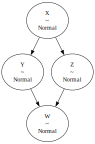

In [2]:
# import graphviz
# import matplotlib as plt
graph = pm.model_to_graphviz(my_model);graph.graph_attr.update(size='8,2');graph

#### 1.1.1. Prior Sampling
You can sample from this model using the `pymc.sample_prior_predictive()` function. 
(Note: the output is a `pymc`-specific object, which can be converted to a `pandas` DataFrame.)

In [3]:
sample = pm.sample_prior_predictive(samples=200, model=my_model, random_seed=0)
sample.to_dataframe() # convert to pandas DataFrame
print(sample.to_dataframe().head(3))

Sampling: [W, X, Y, Z]


   chain  draw         W         X         Y         Z
0      0     0  1.348648  0.805089  1.747188  0.638601
1      0     1 -1.511908 -1.912059 -2.610552  1.016113
2      0     2  3.028636 -3.496649 -1.908144  4.232605


#### Pairwise Correlations ( scatterplots )
The scatterplots below illustrate the pairwise correlations between the variables, which for Normal distributions are equivalent to pairwise dependencies.
(Note: it can be shown that $X\perp W$ *unconditionally*).  

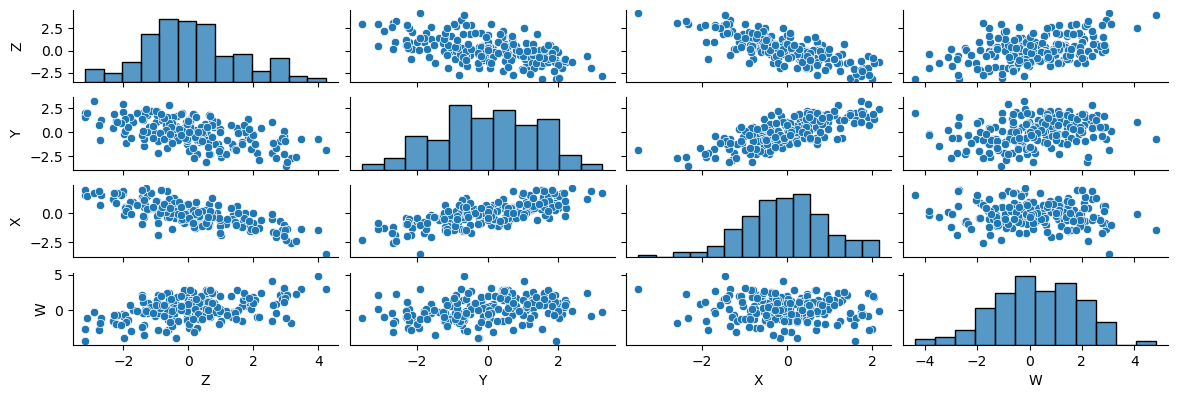

In [4]:
import seaborn as sns
sns.pairplot(
    sample.to_dataframe().drop(['chain', 'draw'], axis=1).iloc[:, ::-1],
    height=1,aspect=3 # Optional, can remove entire line.
);

#### 1.1.2. Posterior Distribution - RVs observed

You can also *fix* the values of one or more RVs as observed, and sample from the *posterior distribution* of the rest: 

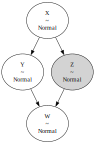

In [5]:
with Model() as my_model:  
    X = Normal( name = "X", mu = 0, sigma = 1 )
    Y = Normal( name = "Y", mu = X, sigma = 1 )
    Z = Normal( name = "Z", mu = -X, sigma = 1 , observed = -1 ) # fix Z value to -1 
    W = Normal( name = "W", mu = Y+Z, sigma = 1 )

graph = pm.model_to_graphviz(my_model);graph.graph_attr.update(size='8,2');graph

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [X, Y, W]


Sampling 1 chain for 1_000 tune and 200 draw iterations (1_000 + 200 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


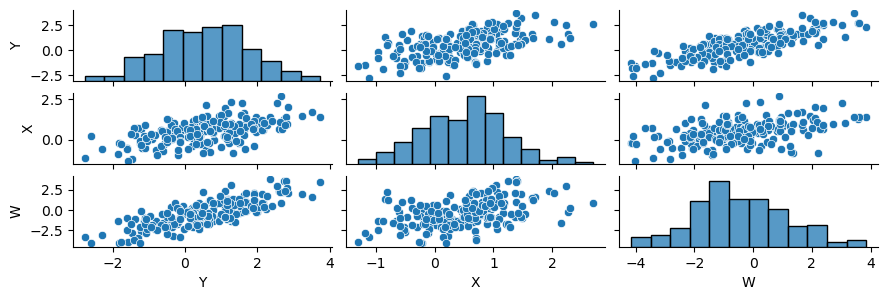

In [6]:
sample = pm.sample( draws = 200, chains = 1, model=my_model, random_seed=0)
#sample = pm.sample(draws=200, chains = 1, tune = 100, model=my_model, random_seed=0)
sample.posterior.to_dataframe() 
import seaborn as sns
sns.pairplot(
    sample.posterior.to_dataframe().iloc[:, ::-1],
    height=1,aspect=3# Optional, can remove entire line.
)

### 1.2. Example:
You will now implement your own Linear Gaussian Bayes net with the following specification:
$$ X\sim \mathcal{N}(0,1), \; Y \sim \mathcal{N}(0,1), \; Z|(X,Y) \sim \mathcal{N}(X+Y,1), \; W|Z \sim \mathcal{N}(Z,1) $$
Generate 200 observations from the model, and plot the pairwise scatterplots and the corresponding DAG. 
Are the pairwise dependencies in the model reflected in the scatterplot?

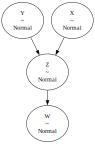

In [7]:
import numpy as np;import pymc as pm;from pymc import Normal, Model

with Model() as my_model:  
    X = Normal( name = "X", mu = 0, sigma = 1 )
    Y = Normal( name = "Y", mu = 0, sigma = 1 )
    Z = Normal( name = "Z", mu = X+Y, sigma = 1 )
    W = Normal( name = "W", mu = Z, sigma = 1 )

# import graphviz; import matplotlib as plt
graph = pm.model_to_graphviz(my_model);graph.graph_attr.update(size='8,2');graph

Sampling: [W, X, Y, Z]


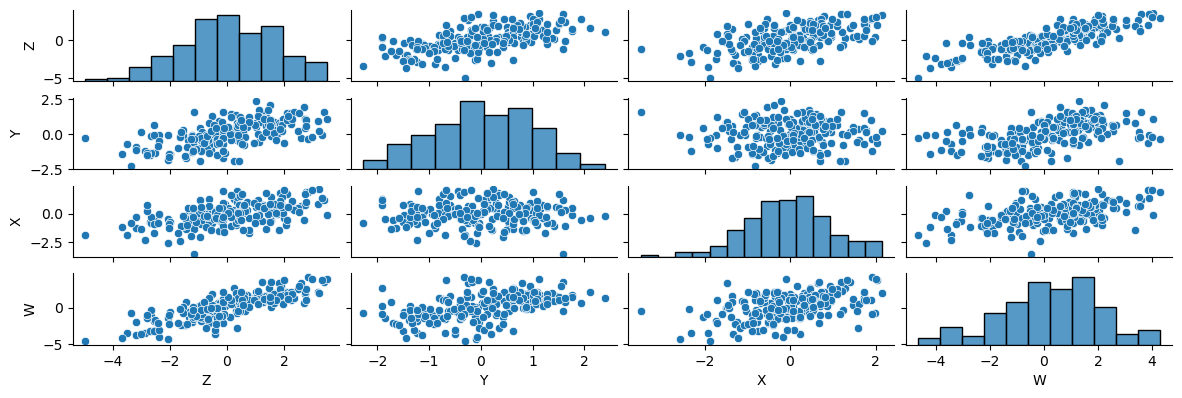

In [8]:
import seaborn as sns
sample = pm.sample_prior_predictive(samples=200, model=my_model, random_seed=0)
sns.pairplot(
    sample.to_dataframe().drop(['chain','draw'], axis = 1).iloc[:, ::-1],
    height=1,aspect=3 # Optional, can remove entire line.
);

# from the scatterplot we can see that only X and Y are (unconditionally) independent/uncorrelated


Now condition on the value of $W=1$, and sample from the posterior distribution of $X,Y,Z$; what kind of dependencies do you see now?

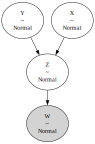

In [9]:
import numpy as np; import pymc as pm; from pymc import Normal, Model
with Model() as my_model:  
    X = Normal( name = "X", mu = 0, sigma = 1 )
    Y = Normal( name = "Y", mu = 0, sigma = 1 )
    Z = Normal( name = "Z", mu = X+Y, sigma = 1 )
    W = Normal( name = "W", mu = Z, sigma = 1, observed = 1 )
    
graph = pm.model_to_graphviz(my_model);graph.graph_attr.update(size='8,2');graph

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [X, Y, Z]


Sampling 1 chain for 100 tune and 200 draw iterations (100 + 200 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


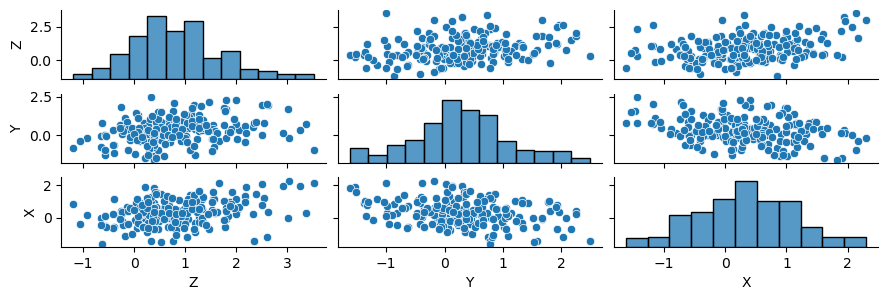

In [10]:
sample = pm.sample(draws=200, chains = 1, tune = 100, model=my_model, random_seed=0)
import seaborn as sns
sns.pairplot(
    sample.posterior.to_dataframe().iloc[:, ::-1],
    height=1,aspect=3# Optional, can remove entire line.
)

# from the scatterplot we can see that only X and Y are (unconditionally) independent/uncorrelated

## 2.Naive Bayes Classifier (Sklearn)

We will now employ a Naive Bayes classifier on the Wisconsin diagnostic breast cancer (wdbc) data. The following code loads the data and splits it into a training and test set. It also fits a Linear Discriminant Analysis (LDA) and reports the out-of-sample performance.

In [11]:
import pandas as pd; from sklearn.datasets import load_breast_cancer
tmp = load_breast_cancer() # load dictinary of 'target' (y) and 'data' (X)  variables
wdbc = pd.DataFrame( data= np.c_[ tmp['target'], tmp['data'] ], # make pandas DataFrame
        columns= ['diagnosis', 'radius_m', 'texture_m', 'perimeter_m', # variable names
         'area_m', 'smoothness_m', 'compactness_m', 'concavity_m','concave_points_m', 'symmetry_m', 'fractal_dimension_m',
         'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se','compactness_se', 'concavity_se', 
        'concave_points_se', 'symmetry_se','fractal_dimension_se', 'radius_w', 'texture_w','perimeter_w', 'area_w', 
        'smoothness_w', 'compactness_w', 'concavity_w', 'concave_points_w','symmetry_w', 'fractal_dimension_w'])
# diagnosis = 0.0 -> benign tumor; diagnosis = 1.0 -> malignant tumor; 
wdbc.diagnosis = np.where( wdbc.diagnosis == 0.0, "malignant", "benign")
X = wdbc.drop('diagnosis', axis = 1).to_numpy()
y = wdbc['diagnosis'].to_numpy()

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, random_state = 12345, test_size=0.20 )

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
clf_LDA = LDA().fit(X_train, y_train)

from sklearn.metrics import classification_report
print( classification_report( y_test, clf_LDA.predict(X_test), labels=['malignant', 'benign']) )

              precision    recall  f1-score   support

   malignant       1.00      0.90      0.95        42
      benign       0.95      1.00      0.97        72

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114



Complete the code below to apply a Gaussian Naive Bayes classifier on the same data, with the `sklearn.naive_bayes.GaussianNB()` function, and report its out-of-sample performance.

In [13]:
from sklearn.naive_bayes import GaussianNB
clf_GNB = GaussianNB().fit(X_train, y_train)

from sklearn.metrics import classification_report
print( classification_report( y_test, clf_GNB.predict(X_test), labels=['malignant', 'benign']) )


              precision    recall  f1-score   support

   malignant       0.95      0.83      0.89        42
      benign       0.91      0.97      0.94        72

    accuracy                           0.92       114
   macro avg       0.93      0.90      0.91       114
weighted avg       0.92      0.92      0.92       114



NOTE: For implementing Naive Bayes, it is much easier to use the `sklearn` library instead of `pymc`. The former uses maximum likelihood to estimate the distribution parameters of every  (independent) feature ($X_i$) for each class ($Y$ value), whereas the latter is meant for a fully Bayesian approach which places priors on the parameters of the conditional distribution of $X_i|Y$. The two can be made equivalent, but the application is way simpler in `sklearn`.